# Diagonalizing coordinate space solutions in 3D

In this notebook you will apply a 2nd-derivative operator and a potential as matrices in coordinate space to represent the Schroedinger equation. By diagonalizing it you'll find its eigenvalues (the energy spectrum) and eigenvectors (wave functions).

What is different here from previous notebooks is that we'll do it in three dimensions. This requires very few changes if we solve for the radial wave function $u_{E\ell}(r) = r R_{E\ell}(r)$. The radial Schrodinger equation for an energy eigenstate is:

$$
 \hat H |\psi\rangle = E |\psi\rangle\quad \doteq\quad  \Bigl[ -\frac{\hbar^2}{2m}\frac{d^2}{dr^2} + \frac{\hbar^2\ell(\ell+1)}{2mr^2} +  V(r)\Bigr] u_{El}(r) = E u_{El}(r) ,
$$

where the full wavefunction is $\psi(\mathbf{x}) = R_{E\ell}(r) Y^m_{\ell}(\theta,\phi)$. (Be careful not to confuse the mass $m$ with the quantum number $m$. The latter will not appear again in this notebook, however, because the energy $E$ and radial function $u_{El}$ depend on $\ell$ but not on this $m$.)

Standard imports plus seaborn (to make plots looks nicer).

In [1]:
import numpy as np
import scipy.linalg as la

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")


We use the now-familiar  `second_derivative_matrix` function below so that it returns a matrix that implements an approximate second derivative when applied to a vector made up of a function evaluated at the mesh points. Now we apply it to functions of $r$ rather than functions of $x$, but that is just labeling; the 2nd derivative has the same form. The numpy `diag` and `ones` functions are used to create matrices with 1's on particular diagonals, as in this $5\times 5$ example: 

$$ \frac{1}{(\Delta r)^2}\,\left( 
    \begin{array}{ccccc}
    -2 & 1 & 0 & 0 & 0 \\
    1 & -2 & 1 & 0 & 0 \\
    0 & 1 & -2 & 1 & 0 \\
    0 & 0 &1 & -2 & 1 \\
    0 & 0 & 0 & 1 & -2
    \end{array}
   \right) 
   \left(\begin{array}{c}
         f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5
         \end{array}
   \right) 
   %\overset{?}{=}
   =
   \left(\begin{array}{c} -2f_1 + f_2
          \\ f_1 - 2 f_2 + f_3  \\ f_2 - 2 f_3 + f_4 \\ f_3 - 2 f_4 + f_5 \\ f_4 - 2 f_5
         \end{array}
   \right) 
 $$  
 

In [2]:
def second_derivative_matrix(N, Delta_r):
    """
    Return an N x N matrix for 2nd derivative of a vector equally spaced by delta_x
    """
    M_temp = np.diag(np.ones(N-1), +1) + np.diag(np.ones(N-1), -1) \
              - 2 * np.diag(np.ones(N), 0)

    return M_temp / (Delta_r**2)

## Setting up the second derivative

**Choose values for `N_pts`, `x_min`, and `x_max`** 

In [3]:
N_pts = 2001   # For accuracy this should be large; over 1000 
r_min = 0.     # For three-dimensions, r starts at zero
r_max = 5.     # How large to make this depends on the potential
Delta_r = (r_max - r_min) / (N_pts - 1)
r_mesh = np.linspace(r_min, r_max, N_pts)  # create the grid ("mesh") of x points

Set up the derivative matrices for the specified mesh.

In [4]:
second_deriv = second_derivative_matrix(N_pts, Delta_r)

## Setting up potentials and Hamiltonian matrix

The Hamiltonian matrix is 

$$
 \hat H \doteq  -\frac{\hbar^2}{2m}\frac{d^2}{dr^2} + \frac{\hbar^2\ell(\ell+1)}{2mr^2} +  V(r) ,
$$

which we'll implement as a sum of matrices. We'll choose units initially so that $\hbar = 1$ and $m = 1$, but these can be set to any desired values.

In [5]:
def V_SHO_matrix(r_mesh):
    """
    Harmonic oscillator potential matrix (defined as a diagonal matrix)
    """
    k = 1/2       # k is chosen so that hbar*omega = 1 
    V_diag = k * r_mesh**2 / 2  # diagonal matrix elements
    N = len(r_mesh)  # number of x points
    
    return V_diag * np.diag(np.ones(N), 0) 

In [6]:
def Three_D_spherical_box(r_mesh, ell, a, beta, mass=1, hbar=1):
    """
    Potential in a box of radius a and depth hbar^2 beta^2 / (2 m a^2).
    """
    V0 = hbar**2 * beta**2 / (2 * mass * a**2)
    Lfact = hbar**2 * ell * (ell + 1) / (2 * mass)
    V_diag = np.array([V0 if r > a else 0 for r in r_mesh])
    V_diag = V_diag + np.array([Lfact / r**2 if r > 0.001 else 0 for r in r_mesh])
    N = len(r_mesh)  # number of r points
    
    return V_diag * np.diag(np.ones(N), 0)     

**Put together the Hamiltonian matrix**

In [7]:
hbar = 1
mass = 1

ell = 0   # pick the value of orbital angular momentum l
a = 1     # radius of the spherical box
beta = 10 # parameter setting the height of the potential wall
V_spherical = Three_D_spherical_box(r_mesh, ell, a, beta, mass=1, hbar=1)

Hamiltonian = -hbar**2/(2*mass) * second_deriv + V_spherical

# Diagonalize using numpy functions
eigvals, eigvecs = np.linalg.eigh(Hamiltonian)

gs = eigvals[0]

print(f' *** Energy eigenvalues for l = {ell} ***')
print(' n       E       ka      ka/pi')
for n, eig in enumerate(eigvals[0:10]):
    print(f' {n}  {eig:8.4f}  {np.sqrt(eig*2*mass*a**2/hbar**2):7.3f} ', \
          f' {np.sqrt(eig*2*mass*a**2/hbar**2)/np.pi:6.3f}')


 *** Energy eigenvalues for l = 0 ***
 n       E       ka      ka/pi
 0    4.0404    2.843    0.905
 1   16.0190    5.660    1.802
 2   35.2503    8.396    2.673
 3   50.2971   10.030    3.193
 4   51.1804   10.117    3.220
 5   52.6230   10.259    3.266
 6   54.5640   10.446    3.325
 7   56.8822   10.666    3.395
 8   59.4578   10.905    3.471
 9   62.4342   11.174    3.557


In [8]:
norm = 1 / np.sqrt(Delta_r)

wf_0 = norm * eigvecs[:,0]
wf_1 = norm * eigvecs[:,1]
wf_2 = norm * eigvecs[:,2]

print(f' test normalization: {Delta_r * wf_0 @ wf_0}')


 test normalization: 0.9999999999999993


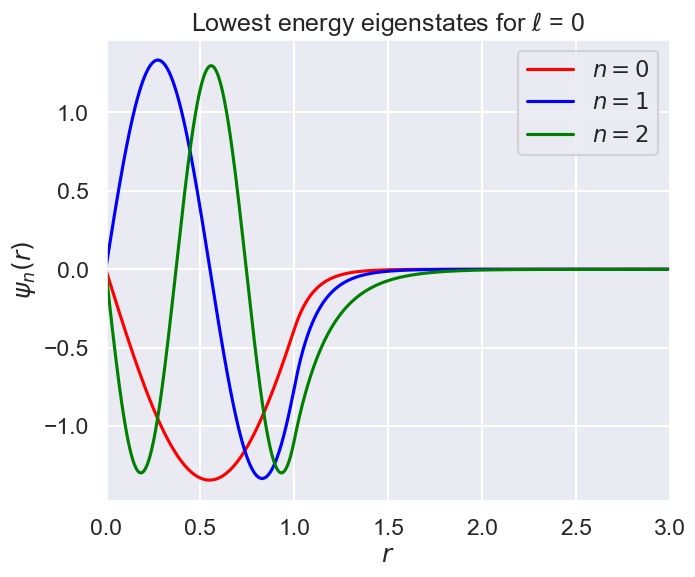

In [9]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$r$')
ax1.set_ylabel(r'$\psi_n(r)$')

r_max = 3 * a
ax1.set_xlim(0, r_max)
#ax1.set_ylim(-1., 3)

ax1.plot(r_mesh, wf_0, color='red', label=r'$n=0$')
ax1.plot(r_mesh, wf_1, color='blue', label=r'$n=1$')
ax1.plot(r_mesh, wf_2, color='green', label=r'$n=2$')

ax1.set_title(fr'Lowest energy eigenstates for $\ell$ = {ell}')

ax1.legend();


In [10]:
hbar = 1
mass = 1

ell = 1   # pick the value of orbital angular momentum l
a = 1     # radius of the spherical box
beta = 10 # parameter setting the height of the potential wall
V_spherical = Three_D_spherical_box(r_mesh, ell, a, beta, mass=1, hbar=1)

Hamiltonian = -hbar**2/(2*mass) * second_deriv + V_spherical

# Diagonalizing using numpy functions
eigvals, eigvecs = np.linalg.eigh(Hamiltonian)

E_gs = eigvals[0]  # ground state energy
print(f' *** Energy eigenvalues for l = {ell} ***')
print(' n       E       ka    ')
for n, eig in enumerate(eigvals[0:10]):
    print(f' {n}  {eig:8.4f}  {np.sqrt(eig*2*mass*a**2/hbar**2):7.3f} ')
    #, \
    #      f' {np.sqrt(eig*2*mass*a**2/hbar**2)/np.pi:6.3f}')



 *** Energy eigenvalues for l = 1 ***
 n       E       ka    
 0    8.2840    4.070 
 1   24.1591    6.951 
 2   46.2234    9.615 
 3   50.4506   10.045 
 4   51.4501   10.144 
 5   53.0405   10.300 
 6   55.2109   10.508 
 7   57.9424   10.765 
 8   61.2070   11.064 
 9   64.9548   11.398 


In [11]:
norm = 1 / np.sqrt(Delta_r)

wf_0 = norm * eigvecs[:,0]
wf_1 = norm * eigvecs[:,1]
wf_2 = norm * eigvecs[:,2]

print(f' test normalization: {Delta_r * wf_0 @ wf_0}')


 test normalization: 0.9999999999999996


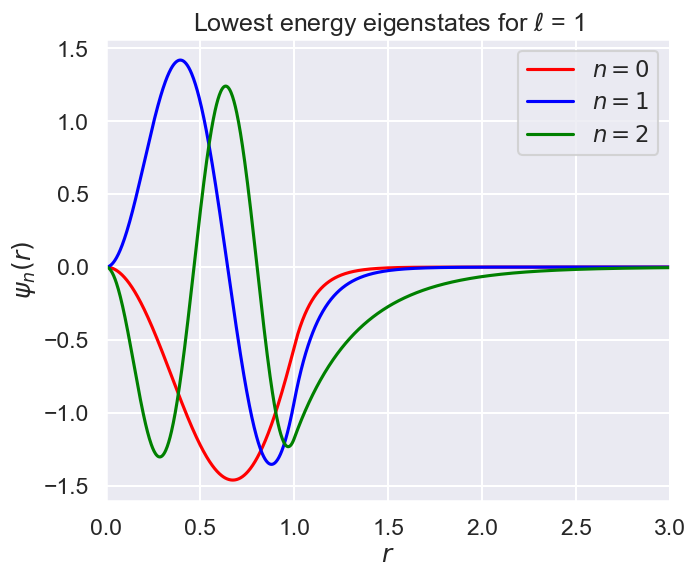

In [12]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$r$')
ax1.set_ylabel(r'$\psi_n(r)$')

r_max = 3 * a
ax1.set_xlim(0, r_max)
#ax1.set_ylim(-1., 3)

ax1.plot(r_mesh, wf_0, color='red', label=r'$n=0$')
ax1.plot(r_mesh, wf_1, color='blue', label=r'$n=1$')
ax1.plot(r_mesh, wf_2, color='green', label=r'$n=2$')

ax1.set_title(fr'Lowest energy eigenstates for $\ell$ = {ell}')

ax1.legend();
